# This notebook computes the Fisher matrix for the 4 parameter secondary 21-cm bispectrum + primordial bispectra as a function of $k_{\rm max}$

In [1]:
import numpy as np
from secondaryBispectrum import *
from bispectra import *
import matplotlib.pyplot as plt
from scipy import interpolate
import vegas
from joblib import Parallel, delayed
%matplotlib inline
plt.rcParams.update({'font.size': 12})
n_jobs=-1 #number of threads

In [2]:
P(2)

4.591415714348764e-09

In [3]:
zs,rs = np.genfromtxt("comovingD.dat").T
znmids = np.arange(1,len(zs),2)

VzTotal = 4.*np.pi/3. * (rs[-1]**3-rs[0]**3)

Vzs = np.array([4.*np.pi/3. * (rs[i+1]**3-rs[i-1]**3) for i in znmids])

In [38]:
np.array([rs[znmids[-1]+1]**3 -  rs[znmids[-1]-1]**3])

array([1.9649958e+10])

In [37]:
(interpolate.interp1d(zs,rs)([100])**3 - interpolate.interp1d(zs,rs)([99])**3)

array([3.86420844e+09])

In [39]:
2*np.pi / (4*np.pi/3 * (interpolate.interp1d(zs,rs)([100])**3 - interpolate.interp1d(zs,rs)([99.9])**3))**(1/3)

array([0.00535037])

(232, 30)


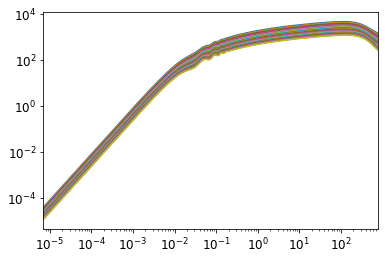

In [4]:
transferdata = np.genfromtxt("BaryonTransfer-z100-z30-delta05.dat")
kTF = transferdata[:,0]
print(transferdata.shape)
TFdata = np.flip(transferdata[:,1:],axis=1)
plt.loglog(kTF,TFdata)
plt.xlim(kTF[0],kTF[-1])
plt.show()
TFint = interpolate.interp1d(kTF,TFdata[:,znmids],axis=0,bounds_error=False)

In [5]:
dataT21 = np.genfromtxt("T21.dat")
dataCoef = np.genfromtxt("alphacoeffdata.dat")

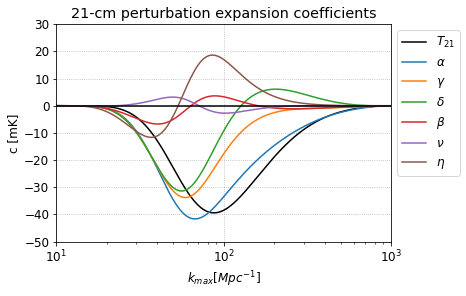

In [6]:
names = ['$T_{21}$','$\\alpha$','$\\gamma$','$\\delta$','$\\beta$','$\\nu$','$\\eta$']
plt.semilogx(dataT21[:,0],dataT21[:,1],'-k',label=names[0])
[plt.semilogx(dataCoef[:,0],dataCoef[:,n],label=names[n]) for n in range(1,dataCoef.shape[1])]
plt.gca().set_prop_cycle(None)
plt.semilogx([10,1000],[0,0],'-k')
plt.xlim(10,1000)
plt.grid(linestyle=":")
plt.xlabel("$k_{max} [Mpc^{-1}]$")
plt.ylabel("c [mK]")
plt.title("21-cm perturbation expansion coefficients")
plt.ylim(-50,30)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [7]:
T21zs = dataT21[:,0]
Coefzs = dataCoef[:,0]

T21s = dataT21[:,1]
alphas = dataCoef[:,1]
betas  = dataCoef[:,4]
gammas = dataCoef[:,2]
deltas = dataCoef[:,3]
nus    = dataCoef[:,5]
etas   = dataCoef[:,6]

## Set up the integral for the Fisher matrix elements

In [55]:
def integrand(k,kmin,kmax,S1,S2,fn,munu,T21,alpha,beta,gamma):
    Fish = np.zeros((len(k),14))
    
    kpmin = kmin
    kpmax = kmax
    kzmin = kmin
    kzmax = kmax

    k1p = kpmin + k[:,0] * (kpmax-kpmin)
    k1zmax = np.sqrt(kmax**2 - k1p**2)
    k1z = np.sign(k[:,1]) * (kzmin + np.abs(k[:,1]) * (k1zmax-kzmin))
    k1  = np.sqrt(k1p**2 + k1z**2)

    k2p = kpmin + k[:,2] * (kpmax-kpmin)
    k2zmax = np.sqrt(kmax**2 - k2p**2)
    k2z = np.sign(k[:,3]) * (kzmin + np.abs(k[:,3]) * (k2zmax-kzmin))
    k2  = np.sqrt(k2p**2 + k2z**2)
    
    phi12 = k[:,4]

    k3p = np.sqrt(k1p**2 + k2p**2 + 2*k1p*k2p*np.cos(phi12))
    k3z = -k1z-k2z
    k3 = np.sqrt(k3p**2 + k3z**2)

    dVol = 2 * 2 * 2*np.pi * k1p * k2p * (kpmax-kpmin) * (kpmax-kpmin) * (k1zmax-kzmin) * (k2zmax-kzmin)
    
    bools = k1 == k1
    for q in [k1,k2,k3]:
        bools*= q < kmax
        bools*= q > kmin
        
    for qp in [k1p,k2p,k3p]:
        bools*= qp < kpmax
        bools*= qp > kpmin
    
    for qz in [k1z,k2z,k3z]:
        bools*= np.abs(qz) > kzmin
        bools*= np.abs(qz) < kzmax

    k1 = k1[bools]
    k1z = k1z[bools]
    k2 = k2[bools]
    k2z = k2z[bools]
    k3 = k3[bools]
    k3z = k3z[bools]

    mu1 = ((k1z/k1)**2)[:,np.newaxis]
    mu2 = ((k2z/k2)**2)[:,np.newaxis]
    mu3 = ((k3z/k3)**2)[:,np.newaxis]

    TF1 = TFint(k1)
    TF2 = TFint(k2)
    TF3 = TFint(k3)

    k1 = k1[:,np.newaxis]
    k2 = k2[:,np.newaxis]
    k3 = k3[:,np.newaxis]
    
    P1prim = P(k1)
    P2prim = P(k2)
    P3prim = P(k3)

    P1 = TF1**2 * P1prim
    P2 = TF2**2 * P2prim
    P3 = TF3**2 * P3prim

    pre1 = alpha + T21 * mu1
    pre2 = alpha + T21 * mu2
    pre3 = alpha + T21 * mu3
    
    P1T = pre1**2 * P1
    P2T = pre2**2 * P2
    P3T = pre3**2 * P3

    if S1 < 4:
        c1 = BSec4Pressure(S1,k1,k2,k3,mu1,mu2,mu3,P1,P2,P3,P1,P2,P3,alpha,beta,gamma,T21)
        c1+= BSec4Pressure(S1,k1,k3,k2,mu1,mu3,mu2,P1,P3,P2,P1,P3,P2,alpha,beta,gamma,T21)
        c1+= BSec4Pressure(S1,k3,k2,k1,mu3,mu2,mu1,P3,P2,P1,P3,P2,P1,alpha,beta,gamma,T21)
    if S1 == 4:
        c1 = pre1*pre2*pre3*TF1*TF2*TF3*fn(P1prim,P2prim,P3prim)
    
    if S2 == S1:
        c2 = c1
    elif S2 < 4:
        c2 = BSec4Pressure(S2,k1,k2,k3,mu1,mu2,mu3,P1,P2,P3,P1,P2,P3,alpha,beta,gamma,T21)
        c2+= BSec4Pressure(S2,k1,k3,k2,mu1,mu3,mu2,P1,P3,P2,P1,P3,P2,alpha,beta,gamma,T21)
        c2+= BSec4Pressure(S2,k3,k2,k1,mu3,mu2,mu1,P3,P2,P1,P3,P2,P1,alpha,beta,gamma,T21)
    elif S2 == 4:
        c2 = pre1*pre2*pre3*TF1*TF2*TF3*fn(P1prim,P2prim,P3prim)

    Fish[bools] = c1*c2/6/P1T/P2T/P3T
    Fish *= Vzs[np.newaxis,:]
    
    result = np.sum(Fish,axis=1) /(2*np.pi)**6 * dVol
    return result

def Fisher(kmin,kmax,S1,S2,fn,munu,rtol):
    integ = vegas.Integrator([[0,1],[0,1],[0,1],[-1,1],[0,np.pi]])
    zmids = zs[znmids]
    T21 = np.interp(zmids,T21zs,T21s)[np.newaxis,:]
    alpha = np.interp(zmids,Coefzs,alphas)[np.newaxis,:]
    beta = np.interp(zmids,Coefzs,betas)[np.newaxis,:]
    gamma = np.interp(zmids,Coefzs,gammas)[np.newaxis,:]

    @vegas.batchintegrand
    def integrandbatch(k):
        return integrand(k,kmin,kmax,S1,S2,fn,munu,T21,alpha,beta,gamma)

    pre = integ(integrandbatch,nitn=10,neval=1e5,rtol=rtol)
    print(pre.summary())

    results = integ(integrandbatch,nitn=100,neval=1e6,rtol=rtol)
    print(results.summary())
    mean = results.mean
    rerr = np.abs(results.sdev/mean)
    
#     print(S1,S2,mean,rerr)
    return kmax, S1, S2, mean, rerr

%time Fisher(0.01,300,4,4,BLocal,0,1e-3)[-2]**-.5

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   2.72(37)e+10    2.72(37)e+10        0.00     1.00
  2   2.88(21)e+10    2.84(18)e+10        0.13     0.72
  3   5.3(2.0)e+10    2.86(18)e+10        0.80     0.45
  4   4.82(99)e+10    2.92(18)e+10        1.79     0.15
  5   3.72(17)e+10    3.35(12)e+10        4.04     0.00
  6   3.77(12)e+10    3.559(87)e+10       4.44     0.00
  7   4.47(42)e+10    3.596(85)e+10       4.45     0.00
  8   4.23(26)e+10    3.656(81)e+10       4.58     0.00
  9   4.12(15)e+10    3.763(71)e+10       4.95     0.00
 10   4.16(10)e+10    3.897(58)e+10       5.59     0.00

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   4.16(12)e+10    4.16(12)e+10        0.00     1.00
  2   4.46(16)e+10    4.263(94)e+10       2.28     0.13
  3   4.42(12)e+10    4.322(74)e+10       1.64     0.19
  4   4.62(35)e+10    4.334(72)e+10       1.33 

4.814686008698861e-06

## Compute Fisher Matrix

In [33]:
ks = [0.3,1,3,10,30,100,300]
tasks = [delayed(Fisher)(0.01,km,S1,S2,None,0,1e-4) for km in ks for S1 in range(4) for S2 in range(0,S1+1)]
print(len(tasks),'tasks')
tasks=tasks[::-1]
data = np.array(Parallel(n_jobs=-1,verbose=10)(tasks))
data = data[::-1]
np.savetxt(f"Secondaries7ks.dat",data)

70 tasks


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 27 concurrent workers.


2099823.817548] [pg-node210:7586 :0]          ib_md.c:1162 UCX  WARN  IB: data corruption might occur when using registered memory.
[1652099823.830403] [pg-node210:7586 :0]          ib_md.c:1161 UCX  WARN  IB: ibv_fork_init() was disabled or failed, yet a fork() has been issued.
[1652099823.830416] [pg-node210:7586 :0]          ib_md.c:1162 UCX  WARN  IB: data corruption might occur when using registered memory.
[1652099823.840625] [pg-node210:7586 :0]          ib_md.c:1161 UCX  WARN  IB: ibv_fork_init() was disabled or failed, yet a fork() has been issued.
[1652099823.840637] [pg-node210:7586 :0]          ib_md.c:1162 UCX  WARN  IB: data corruption might occur when using registered memory.
[1652099823.856704] [pg-node210:7586 :0]          ib_md.c:1161 UCX  WARN  IB: ibv_fork_init() was disabled or failed, yet a fork() has been issued.
[1652099823.856718] [pg-node210:7586 :0]          ib_md.c:1162 UCX  WARN  IB: data corruption might occur when using registered memory.
[1652100446.7406

[Parallel(n_jobs=-1)]: Done  19 out of  54 | elapsed:  6.6min remaining: 12.1min
[Parallel(n_jobs=-1)]: Done  25 out of  54 | elapsed:  6.6min remaining:  7.6min
[Parallel(n_jobs=-1)]: Done  31 out of  54 | elapsed:  6.6min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done  37 out of  54 | elapsed:  6.6min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  43 out of  54 | elapsed:  6.6min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  49 out of  54 | elapsed:  6.6min remaining:   40.2s
[pg-node210:27322] PMIX ERROR: UNPACK-PAST-END in file src/client/pmix_client.c at line 100
Process LokyProcess-109:
Process LokyProcess-107:
Process LokyProcess-115:
Process LokyProcess-110:
Process LokyProcess-103:
Traceback (most recent call last):
  File "/software/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "/software/software/Python/3.9.5-GCCcore-10.3.0/lib/python3.9/site-packages/jobli

KeyboardInterrupt: 

In [11]:
ks = [0.3,1,3,10,30,100,300]
shapes = [BLocal,BEquil,BOrtho]
for shape in shapes:
    tasks = [delayed(Fisher)(0.01,km,S1,4,shape,0,1e-4) for km in ks for S1 in range(5)]
    print(len(tasks),'tasks')
    tasks=tasks[::-1]
    data = np.array(Parallel(n_jobs=-1,verbose=10)(tasks))
    data = data[::-1]
    np.savetxt(f"Secondaries7ks{shape}.dat",data)

35 tasks


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 27 concurrent workers.


: ibv_fork_init() was disabled or failed, yet a fork() has been issued.
[1652099302.293786] [pg-node210:7586 :0]          ib_md.c:1162 UCX  WARN  IB: data corruption might occur when using registered memory.
[1652099302.304981] [pg-node210:7586 :0]          ib_md.c:1161 UCX  WARN  IB: ibv_fork_init() was disabled or failed, yet a fork() has been issued.
[1652099302.304988] [pg-node210:7586 :0]          ib_md.c:1162 UCX  WARN  IB: data corruption might occur when using registered memory.
[1652099302.313809] [pg-node210:7586 :0]          ib_md.c:1161 UCX  WARN  IB: ibv_fork_init() was disabled or failed, yet a fork() has been issued.
[1652099302.313826] [pg-node210:7586 :0]          ib_md.c:1162 UCX  WARN  IB: data corruption might occur when using registered memory.
[1652099302.320713] [pg-node210:7586 :0]          ib_md.c:1161 UCX  WARN  IB: ibv_fork_init() was disabled or failed, yet a fork() has been issued.
[1652099302.320724] [pg-node210:7586 :0]          ib_md.c:1162 UCX  WARN  IB

[Parallel(n_jobs=-1)]: Done   2 out of  35 | elapsed:   18.6s remaining:  5.1min
[Parallel(n_jobs=-1)]: Done   6 out of  35 | elapsed:   30.0s remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  10 out of  35 | elapsed:   39.2s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  14 out of  35 | elapsed:   40.4s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  18 out of  35 | elapsed:   56.0s remaining:   52.9s
[Parallel(n_jobs=-1)]: Done  22 out of  35 | elapsed:  2.7min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  26 out of  35 | elapsed:  3.6min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  30 out of  35 | elapsed:  4.9min remaining:   49.4s


35 tasks


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  8.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 27 concurrent workers.


7586 :0]          ib_md.c:1161 UCX  WARN  IB: ibv_fork_init() was disabled or failed, yet a fork() has been issued.
[1652099318.403314] [pg-node210:7586 :0]          ib_md.c:1162 UCX  WARN  IB: data corruption might occur when using registered memory.
[1652099318.413132] [pg-node210:7586 :0]          ib_md.c:1161 UCX  WARN  IB: ibv_fork_init() was disabled or failed, yet a fork() has been issued.
[1652099318.413142] [pg-node210:7586 :0]          ib_md.c:1162 UCX  WARN  IB: data corruption might occur when using registered memory.
[1652099318.420574] [pg-node210:7586 :0]          ib_md.c:1161 UCX  WARN  IB: ibv_fork_init() was disabled or failed, yet a fork() has been issued.
[1652099318.420587] [pg-node210:7586 :0]          ib_md.c:1162 UCX  WARN  IB: data corruption might occur when using registered memory.
[1652099823.702767] [pg-node210:7586 :0]          ib_md.c:1161 UCX  WARN  IB: ibv_fork_init() was disabled or failed, yet a fork() has been issued.
[1652099823.702782] [pg-node210:

[Parallel(n_jobs=-1)]: Done   2 out of  35 | elapsed:    3.3s remaining:   54.0s
[Parallel(n_jobs=-1)]: Done   6 out of  35 | elapsed:    4.9s remaining:   23.5s
[Parallel(n_jobs=-1)]: Done  10 out of  35 | elapsed:    6.3s remaining:   15.8s
[Parallel(n_jobs=-1)]: Done  14 out of  35 | elapsed:    6.9s remaining:   10.4s
[Parallel(n_jobs=-1)]: Done  18 out of  35 | elapsed:    7.4s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done  22 out of  35 | elapsed:    7.6s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  26 out of  35 | elapsed:    8.6s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  30 out of  35 | elapsed:    9.4s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   11.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 27 concurrent workers.


35 tasks


[Parallel(n_jobs=-1)]: Done   2 out of  35 | elapsed:    7.7s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   6 out of  35 | elapsed:    8.4s remaining:   40.7s
[Parallel(n_jobs=-1)]: Done  10 out of  35 | elapsed:   17.1s remaining:   42.7s
[Parallel(n_jobs=-1)]: Done  14 out of  35 | elapsed:   19.5s remaining:   29.2s
[Parallel(n_jobs=-1)]: Done  18 out of  35 | elapsed:   22.3s remaining:   21.0s
[Parallel(n_jobs=-1)]: Done  22 out of  35 | elapsed:   25.2s remaining:   14.9s
[Parallel(n_jobs=-1)]: Done  26 out of  35 | elapsed:   26.0s remaining:    9.0s
[Parallel(n_jobs=-1)]: Done  30 out of  35 | elapsed:   28.4s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   37.5s finished


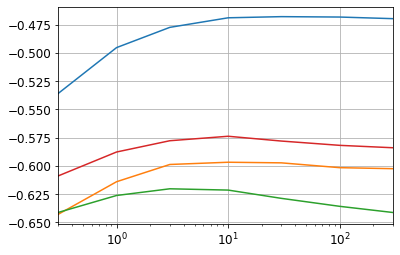

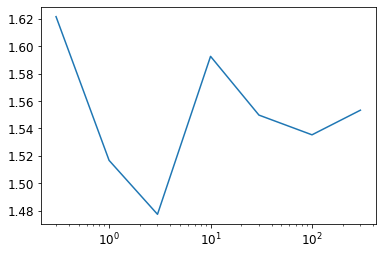

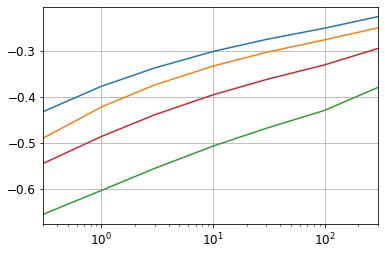

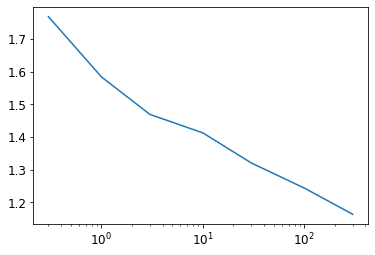

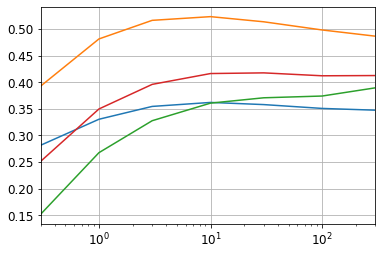

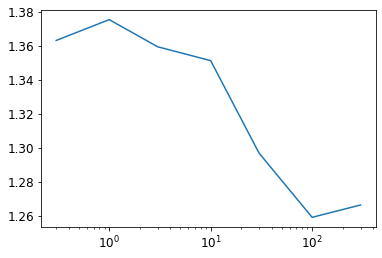

In [54]:
ks = [0.3,1,3,10,30,100,300]
shapes = ["BLocal","BEquil","BOrtho"]
for shape in shapes:
    Fish = np.zeros((7,5,5))

    secdata = np.loadtxt("Secondaries7ks.dat")
    primdata = np.loadtxt(f"Secondaries7ks{shape}.dat")

    a=0
    for ki,km in enumerate(ks):
        for s1 in range(4):
            for s2 in range(0,s1+1):
                Fish[ki,s1,s2] = Fish[ki,s2,s1] = secdata[a,-2]
                a+=1
                
    a=0
    for ki,km in enumerate(ks):
        for s1 in range(5):
                Fish[ki,s1,4] = Fish[ki,4,s1] = primdata[a,-2]
                a+=1
    
    Fish = Fish[:,::-1,::-1]
    
    cs = np.array([Fish[:,i,0] / np.sqrt(Fish[:,0,0]*Fish[:,i,i]) for i in range(1,5)]).T
    plt.semilogx(ks,cs)
    plt.xlim(ks[0],ks[-1])
#     plt.ylim(-1,1)
    plt.grid()
    plt.show()
    
    plt.semilogx(ks,np.sqrt(Fish[:,0,0] * np.linalg.inv(Fish)[:,0,0]))
    plt.show()